In [1]:
import os
import datetime
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
import seaborn as sns

from src.default_paths import path_root
from src.utils import list_dir, get_best_clmbr_model
from src.mappings import model_names

Here we take a look at time to best loss between clmbr_mimic and CLMBR_DAPT. 

In [42]:
path_models = os.path.join(path_root, "data/clmbr_models")
path_save = os.path.join(path_root, "results/figures/supplementary")
os.makedirs(path_save, exist_ok=True)

In [43]:
all_paths = {}
for model in list_dir(path_models):
    if "clmbr_stanford_cp" in model or "clmbr_mimic" in model:
        for i, i_model in enumerate(list_dir(os.path.join(path_models, model))):
            if i_model == "patients_file":
                continue 
            
            all_paths[f"{model}_{i}"] = os.path.join(
                path_models, 
                model, 
                i_model
            )

In [44]:
def get_loss_from_line(line):
    return line.split("'loss': ")[1].split(",")[0]

def get_datetime_from_line(line):
    str_datetime = line.split("[")[0].split(",")[0]
    str_date, str_ts = str_datetime.split(" ")
    y, m, d = [int(x) for x in str_date.split('-')]
    h, mi, s = [int(x) for x in str_ts.split(':')] 
    return datetime.datetime(y,m,d,h,mi,s)

In [52]:
losses = {}
results = pd.DataFrame()
for model, path_model in all_paths.items():
    
    losses[model] = {
        "dev_loss": [],
        "dev_loss_datetime": []
    }
    
    path_log = os.path.join(path_model, "clmbr_model", "log")
    
    with open(path_log, "r") as f:
        for line in f:
            if "[Step 0]" in line:
                losses[model]["starting_datetime"] = get_datetime_from_line(line)
            if "Dev loss" in line:
                losses[model]["dev_loss"].append(get_loss_from_line(line))
                losses[model]["dev_loss_datetime"].append(get_datetime_from_line(line))
                
    index_best_model = np.where(
        np.asarray(losses[model]["dev_loss"])==min(losses[model]["dev_loss"])
    )[0][0]
    
    time_to_best_model = round(
        (losses[model]["dev_loss_datetime"][index_best_model] - losses[model]["starting_datetime"]).total_seconds()/3600,
        2
    )

    if "clmbr_mimic" in model:
        model_name = "clmbr_mimic"
    elif "clmbr_stanford_cp" in model:
        model_name = "clmbr_stanford_cp"
    else:
        raise ValueError("Not CLMBR SK or CLMBR Stanford CP")

    subsample_setting = model.split("_")[-2]
    if subsample_setting in ["mimic", "cp"]:
        subsample_setting = "1"
    
    hyperparameter_setting = model.split("_")[-1]
    
    results = pd.concat((
        results,
        pd.DataFrame({
            "model": [model_names[model_name]],
            "model_setting": subsample_setting,
            "hyperparameter_setting": hyperparameter_setting,
            "time_to_best_model": time_to_best_model,
        })
    ))

#### For subsampling experiment

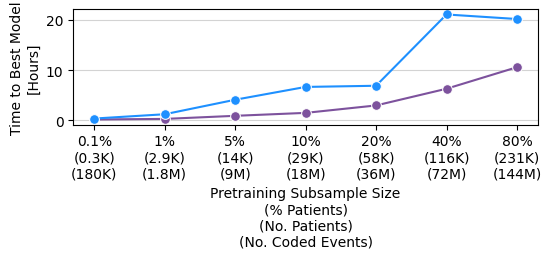

In [53]:
fig,ax = plt.subplots(1,1,figsize=(6,1.5))

results = results.sort_values("model_setting").query("model_setting!='1'")
results = results.assign(
    model_setting = results["model_setting"].replace({
        "0.001": "0.1%\n(0.3K)\n(180K)",
        "0.01": "1%\n(2.9K)\n(1.8M)",
        "0.05": "5%\n(14K)\n(9M)",
        "0.1": "10%\n(29K)\n(18M)",
        "0.2": "20%\n(58K)\n(36M)",
        "0.4": "40%\n(116K)\n(72M)",
        "0.8": "80%\n(231K)\n(144M)",
    })
)

# sns.scatterplot(
#     data=results,
#     x="model_setting",
#     y="time_to_best_model",
#     hue="model",
#     palette={"CLMBR_MIMIC":"dodgerblue", "CLMBR_DAPT":"#7D529D"},
#     alpha=0.2,
#     ax=ax,
#     legend=False,
# )

sns.lineplot(
    data=results,
    x="model_setting",
    y="time_to_best_model",
    hue="model",
    palette={"CLMBR_MIMIC":"dodgerblue", "CLMBR_DAPT":"#7D529D"},
    errorbar=None,
    estimator="mean",
    marker='o',
    markersize=7,
    ax=ax,
    legend=False,
)
ax.grid(axis="y", zorder=0, color='lightgrey')
ax.set_ylabel("Time to Best Model\n[Hours]")
ax.set_xlabel("Pretraining Subsample Size\n(% Patients)\n(No. Patients)\n(No. Coded Events)")
plt.savefig(os.path.join(path_save, "time_to_best_subsample.png"), dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()

#### Across all models

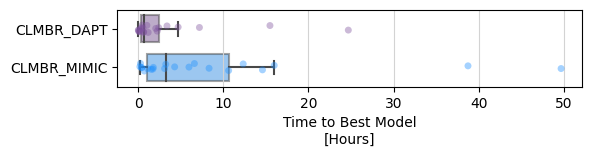

In [49]:
fig, ax = plt.subplots(1,1,figsize=(6,1))
data = results.query("model_setting!='1'")
sns.stripplot(
    data = data,
    y = "model",
    x = "time_to_best_model",
    ax = ax,
    hue = "model",
    palette = {"CLMBR_MIMIC":"dodgerblue", "CLMBR_DAPT":"#7D529D"},
    alpha = 0.4,
    legend=False
)

sns.boxplot(
    data = data,
    y = "model",
    x = "time_to_best_model",
    showfliers=False,
    palette = {"CLMBR_MIMIC":"dodgerblue", "CLMBR_DAPT":"#7D529D"},
    orient = "h",
    width = 0.7,
    ax = ax,
    boxprops=dict(alpha=.5)
)

ax.grid(axis="x", zorder=0, color='lightgrey')
ax.set_xlabel("Time to Best Model\n[Hours]")
ax.set_ylabel("")
plt.savefig(os.path.join(path_save, "time_to_best_all.png"), dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()